In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, ColumnTransformer

In [3]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
train_data["Set"] = "Train"

train_target = train_data["Transported"].astype(int)
train_data.drop(columns="Transported", inplace=True)

test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
test_data["Set"] = "Test"
data = pd.concat([train_data, test_data], axis=0)

In [4]:
print(data["Cabin"].str.split("/")[:10])
data.Cabin.apply(lambda x: len(str(x).split("/"))).describe()

0    [B, 0, P]
1    [F, 0, S]
2    [A, 0, S]
3    [A, 0, S]
4    [F, 1, S]
5    [F, 0, P]
6    [F, 2, S]
7    [G, 0, S]
8    [F, 3, S]
9    [B, 1, P]
Name: Cabin, dtype: object


count    12970.000000
mean         2.953894
std          0.300157
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: Cabin, dtype: float64

In [5]:
new_cabin_features = pd.DataFrame(
    np.concatenate(
        data[data["Cabin"].notnull()]["Cabin"].apply(
            lambda x: str(x).split("/")).values, axis=0
    ).reshape(-1, 3),
    columns = [f"Cabin_F_{x}" for x in range(3)]
)

In [6]:
print(new_cabin_features.sample(5))
new_cabin_features["Cabin_F_1"] = new_cabin_features["Cabin_F_1"].astype(float)

      Cabin_F_0 Cabin_F_1 Cabin_F_2
9717          F       548         P
4626          E       314         P
12376         F      1672         S
1824          G       318         S
10531         F       923         P


In [7]:
new_id_features = pd.DataFrame(
    np.concatenate(
        data[data["PassengerId"].notnull()]["PassengerId"].apply(
            lambda x: str(x).split("_")).values, axis=0
    ).reshape(-1, 2),
    columns = [f"Id_F_{x}" for x in range(2)]
)

In [8]:
print(new_id_features.Id_F_1.value_counts())
new_id_features["Id_F_0"] = new_id_features["Id_F_0"].astype(float)

01    9280
02    2135
03     840
04     338
05     184
06     108
07      66
08      19
Name: Id_F_1, dtype: int64


In [9]:
data[new_cabin_features.columns] = np.nan
data.loc[data["Cabin"].notnull(), new_cabin_features.columns] = new_cabin_features
data.drop(columns="Cabin", inplace=True)

In [10]:
data[new_id_features.columns] = new_id_features
data.drop(columns=["Name", "PassengerId"], inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12682 non-null  object 
 1   CryoSleep     12660 non-null  object 
 2   Destination   12696 non-null  object 
 3   Age           12700 non-null  float64
 4   VIP           12674 non-null  object 
 5   RoomService   12707 non-null  float64
 6   FoodCourt     12681 non-null  float64
 7   ShoppingMall  12664 non-null  float64
 8   Spa           12686 non-null  float64
 9   VRDeck        12702 non-null  float64
 10  Set           12970 non-null  object 
 11  Cabin_F_0     12671 non-null  object 
 12  Cabin_F_1     12671 non-null  float64
 13  Cabin_F_2     12671 non-null  object 
 14  Id_F_0        12970 non-null  float64
 15  Id_F_1        12970 non-null  object 
dtypes: float64(8), object(8)
memory usage: 1.7+ MB


In [12]:
cat_encoder = OneHotEncoder(
#     handle_unknown="use_encoded_value",  # for ordinal encoder
#     unknown_value=-1
    ) 
cat_selector = make_column_selector(
    dtype_exclude=float
    )

float_encoder = StandardScaler()
float_selector = make_column_selector(
    dtype_include=float
    )

transofrmer = ColumnTransformer(
    [("categorical", cat_encoder, cat_selector),
    ("float", float_encoder, float_selector)],
    remainder="passthrough"
    )

In [13]:
# fill missing categorical data with the most frequent entry
for col in cat_selector(data):
    data.loc[data[col].isnull(), col] =\
    data.loc[data[col].notnull(), col].mode().values[0]#= value_counts().index[0]

In [14]:
transofrmer.fit(data)
transofrmer.transformers_

[('categorical',
  OneHotEncoder(),
  ['HomePlanet',
   'CryoSleep',
   'Destination',
   'VIP',
   'Set',
   'Cabin_F_0',
   'Cabin_F_2',
   'Id_F_1']),
 ('float',
  StandardScaler(),
  ['Age',
   'RoomService',
   'FoodCourt',
   'ShoppingMall',
   'Spa',
   'VRDeck',
   'Cabin_F_1',
   'Id_F_0'])]

In [15]:
processed_data = pd.DataFrame(
    transofrmer.transform(data),
#     columns = transofrmer.transformers_[0][-1] + \  # for ordinal encoder
#     transofrmer.transformers_[1][-1]
    columns = np.hstack(
        (transofrmer.transformers_[0][1].get_feature_names_out(),
         transofrmer.transformers_[1][-1]))
)

# processed_data.loc[:, transofrmer.transformers_[0][-1]] =\
# processed_data.loc[:, transofrmer.transformers_[0][-1]].fillna(-1)
processed_data.loc[:, transofrmer.transformers_[0][1].get_feature_names_out()] =\
processed_data.loc[:, transofrmer.transformers_[0][1].get_feature_names_out()].fillna(-1)

processed_data.loc[:, transofrmer.transformers_[1][-1]] =\
processed_data.loc[:, transofrmer.transformers_[1][-1]].fillna(0)

processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HomePlanet_Earth           12970 non-null  float64
 1   HomePlanet_Europa          12970 non-null  float64
 2   HomePlanet_Mars            12970 non-null  float64
 3   CryoSleep_False            12970 non-null  float64
 4   CryoSleep_True             12970 non-null  float64
 5   Destination_55 Cancri e    12970 non-null  float64
 6   Destination_PSO J318.5-22  12970 non-null  float64
 7   Destination_TRAPPIST-1e    12970 non-null  float64
 8   VIP_False                  12970 non-null  float64
 9   VIP_True                   12970 non-null  float64
 10  Set_Test                   12970 non-null  float64
 11  Set_Train                  12970 non-null  float64
 12  Cabin_F_0_A                12970 non-null  float64
 13  Cabin_F_0_B                12970 non-null  flo

In [16]:
processed_data.Set_Train.value_counts()

1.0    8693
0.0    4277
Name: Set_Train, dtype: int64

In [17]:
# train_data = processed_data.loc[processed_data["Set"] > 0].copy()
# train_data.drop(columns=["Set", "Id_F_0","Transported"], inplace=True)
# test_data = processed_data.loc[processed_data["Set"] <= 0].copy()
# test_data.drop(columns=["Set", "Id_F_0","Transported"], inplace=True)

train_data = processed_data.loc[processed_data["Set_Train"] > 0].copy()
train_data.drop(
    columns=["Set_Train", "Set_Test", "Id_F_0"],
    inplace=True)
test_data = processed_data.loc[processed_data["Set_Test"] > 0].copy()
test_data.drop(
    columns=["Set_Train", "Set_Test", "Id_F_0"],
    inplace=True)

array([[<AxesSubplot:title={'center':'HomePlanet_Earth'}>,
        <AxesSubplot:title={'center':'HomePlanet_Europa'}>,
        <AxesSubplot:title={'center':'HomePlanet_Mars'}>,
        <AxesSubplot:title={'center':'CryoSleep_False'}>,
        <AxesSubplot:title={'center':'CryoSleep_True'}>,
        <AxesSubplot:title={'center':'Destination_55 Cancri e'}>],
       [<AxesSubplot:title={'center':'Destination_PSO J318.5-22'}>,
        <AxesSubplot:title={'center':'Destination_TRAPPIST-1e'}>,
        <AxesSubplot:title={'center':'VIP_False'}>,
        <AxesSubplot:title={'center':'VIP_True'}>,
        <AxesSubplot:title={'center':'Cabin_F_0_A'}>,
        <AxesSubplot:title={'center':'Cabin_F_0_B'}>],
       [<AxesSubplot:title={'center':'Cabin_F_0_C'}>,
        <AxesSubplot:title={'center':'Cabin_F_0_D'}>,
        <AxesSubplot:title={'center':'Cabin_F_0_E'}>,
        <AxesSubplot:title={'center':'Cabin_F_0_F'}>,
        <AxesSubplot:title={'center':'Cabin_F_0_G'}>,
        <AxesSubplot:titl

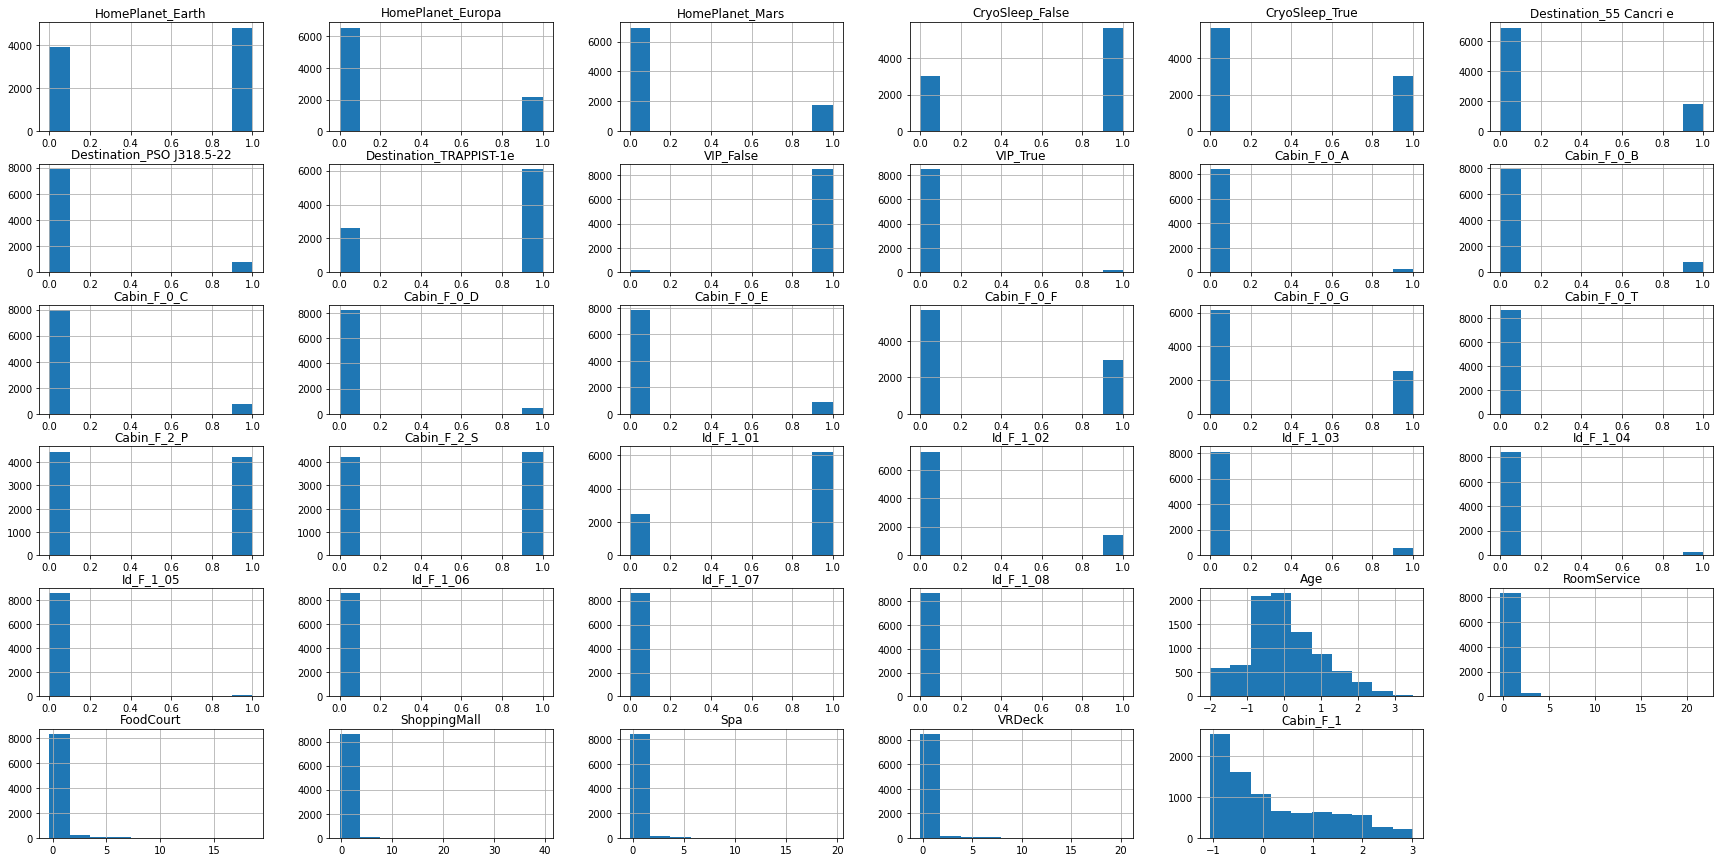

In [18]:
train_data.hist(figsize=(30,15))

In [19]:
passengers = keras.Input(shape=(train_data.shape[1],), name="passenger")

mid_layers = keras.layers.Dense(2048,
                                kernel_regularizer= keras.regularizers.l2(0.001),
                                activation="relu")(passengers)
mid_layers = keras.layers.Dropout(0.2)(mid_layers)

mid_layers = keras.layers.Dense(2048,
                                kernel_regularizer= keras.regularizers.l2(0.001),
                                activation="relu")(mid_layers)
mid_layers = keras.layers.Dropout(0.2)(mid_layers)

mid_layers = keras.layers.Dense(2048,
                                kernel_regularizer= keras.regularizers.l2(0.001),
                                activation="relu")(mid_layers)
mid_layers = keras.layers.Dropout(0.2)(mid_layers)

# mid_layers = keras.layers.Dense(1024,
#                                 kernel_regularizer= keras.regularizers.l2(0.001),
#                                 activation="relu")(mid_layers)
# mid_layers = keras.layers.Dropout(0.2)(mid_layers)

vitals = keras.layers.Dense(1, activation="sigmoid", name="vitals")(mid_layers)

2022-07-17 13:37:05.108416: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
# model = keras.Model(inputs=passengers, outputs=vitals)
# model.compile(optimizer=keras.optimizers.RMSprop(5e-4),
#               loss="BinaryCrossentropy",
#               metrics=["accuracy"])

In [21]:
epochs_num = 20
histories = []
model = keras.Model(inputs=passengers, outputs=vitals)
for rate in [1e-3, 1e-4, 5e-5]:
    print(f"Training at {rate:.5f} rate\n")
    model.compile(optimizer=keras.optimizers.RMSprop(rate),
              loss="BinaryCrossentropy",
              metrics=["accuracy"])
    history = model.fit(train_data, train_target, batch_size=4300,
                        epochs=epochs_num, validation_split=.25, shuffle=True)
    histories.append(history)
    print("")

Training at 0.00100 rate

Epoch 1/20


2022-07-17 13:37:05.442874: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2/2 [==============================] - 5s 1s/step - loss: 4.5885 - accuracy: 0.5668 - val_loss: 15.2227 - val_accuracy: 0.4793
Epoch 2/20
2/2 [==============================] - 3s 1s/step - loss: 10.3287 - accuracy: 0.5117 - val_loss: 3.3966 - val_accuracy: 0.5271
Epoch 3/20
2/2 [==============================] - 3s 1s/step - loss: 3.3260 - accuracy: 0.5622 - val_loss: 2.9431 - val_accuracy: 0.7921
Epoch 4/20
2/2 [==============================] - 3s 1s/step - loss: 2.9109 - accuracy: 0.7474 - val_loss: 2.7380 - val_accuracy: 0.7456
Epoch 5/20
2/2 [==============================] - 3s 1s/step - loss: 2.8145 - accuracy: 0.6679 - val_loss: 2.5092 - val_accuracy: 0.7263
Epoch 6/20
2/2 [==============================] - 3s 1s/step - loss: 2.4513 - accuracy: 0.7731 - val_loss: 2.2726 - val_accuracy: 0.7852
Epoch 7/20
2/2 [==============================] - 3s 1s/step - loss: 2.2511 - accuracy: 0.7851 - val_loss: 2.1178 - val_accuracy: 0.7792
Epoch 8/20
2/2 [==============================] - 

In [22]:
for _ in range(5):
    sample = train_data.sample(4000)
    # train_target[sample.index]
    model.evaluate(sample, train_target[sample.index])

125/125 [==============================] - 2s 17ms/step - loss: 0.7028 - accuracy: 0.7990


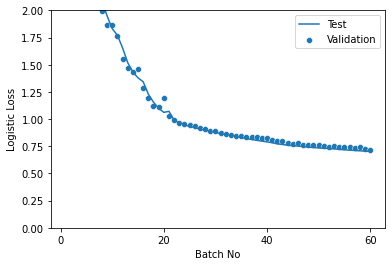

In [23]:
loss, val_loss = [], []
for h in histories:
    loss += h.history["loss"].copy()
    val_loss += h.history["val_loss"].copy()
g_loss = sns.lineplot(x = range(1, len(loss)+1), y=loss, label="Test")
sns.scatterplot(x = range(1, len(loss)+1), y=val_loss, ax=g_loss, label="Validation")
g_loss.set_ylim(0,2)
g_loss.set_ylabel("Logistic Loss")
g_loss.set_xlabel("Batch No")
g_loss.set_xticks(range(0,len(loss)+epochs_num, epochs_num))

Text(0.5, 0, 'Batch No')

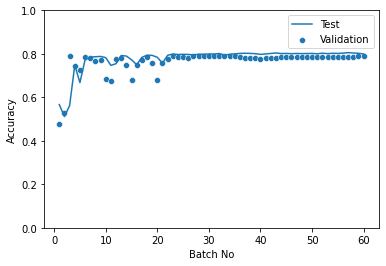

In [24]:
acc, val_acc = [], []
for h in histories:
    acc += h.history["accuracy"].copy()
    val_acc += h.history["val_accuracy"].copy()
g_acc = sns.lineplot(x = range(1, len(acc)+1), y=acc, label="Test")
sns.scatterplot(x = range(1, len(acc)+1), y=val_acc, ax=g_acc, label="Validation")
g_acc.set_ylim(0,1)
g_acc.set_ylabel("Accuracy")
g_acc.set_xlabel("Batch No")

In [25]:
keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
passenger (InputLayer)       [(None, 35)]              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              73728     
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0     

In [26]:
predict = model.predict(test_data)
predict = pd.Series(predict.reshape(-1,))

In [27]:
predict = predict.apply(lambda x: True if x>=.5 else False)
predict.value_counts()

False    2172
True     2105
dtype: int64

In [28]:
submit = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
submit["Transported"] = predict

In [29]:
submit.to_csv("submission.csv", index=False)

In [30]:
submit

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
